In [4]:
#MDVRPTW
#multi-depot and multi-vehicle version of CVRPTW
import pandas as pd
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import networkx as nx
import random

rnd = np.random
rnd.seed(0)


In [5]:
def vrptw_cplex(dataframe, capacity=200, depot_number=1, vehicle_number=2):
    print(dataframe.head())
    depot_data = dataframe[0:1]
    if depot_number > 1:
        for i in range(1, depot_number):
            rand_x = random.randint(min(dataframe["XCOORD."]), max(dataframe["XCOORD."]))
            rand_y = random.randint(min(dataframe["YCOORD."]), max(dataframe["YCOORD."]))

            added_depot = {"CUST_NO.": 0,"XCOORD.": rand_x, "YCOORD.": rand_y, "DEMAND": 0, "READY_TIME":0,"DUE_DATE":max(depot_data["DUE_DATE"]), "SERVICE_TIME": 0.0}
            added_depot = pd.DataFrame(added_depot, index=[i])
            depot_data = pd.concat([added_depot, depot_data])
    
    depot_data = depot_data.reset_index(drop=True)
    print("Depot data \n", depot_data, "\n")

    clients = dataframe[1:]
    clients = clients.reset_index(drop=True)
    print(clients)

    ## Number of vehicles
    K = [i for i in range(vehicle_number)]

    M = 20
    n = len(clients)
    Q = capacity
    N = [i for i in range(len(depot_data), n + len(depot_data))]
    D = [i for i in range(len(depot_data))]
    V = D + N
    
    demands = {}
    for i in V:
        if i in D:
            demands[i] = depot_data["DEMAND"][i]
        elif i in N:
            demands[i] = clients["DEMAND"][i-len(D)]

    # velocity = 20
    print("===============")
    print("demands", demands)
    print("V", V)
    print("D", D)
    print("N", N)
    print("K", K)
    print("===============\n")

    loc_x = [None]*len(V)
    loc_y = [None]*len(V)
    for i in range(len(V)):
        if i in D:
            loc_x[i] = depot_data["XCOORD."][i]
            loc_y[i] = depot_data["YCOORD."][i]
        elif i in N:
            loc_x[i] = clients["XCOORD."][i-len(D)]
            loc_y[i] = clients["YCOORD."][i-len(D)]

    print(loc_x)
    print(loc_y)
    print("===============\n")

    KV = [(i,j,k) for i in V for j in V for k in K if i!=j]
    KA = [(i, k) for i in V for k in K]
    KV2 = [(i, k) for i in V for k in K]
    # A: List of Arcs
    A = [(i, j) for i in V for j in V if i != j]  
    # c: Dictionary of distances/costs
    c = {(i, j): round(np.hypot(loc_x[i] - loc_x[j], loc_y[i] - loc_y[j])) for i, j in A}  
    # print(c)

    T_max = max(dataframe["DUE_DATE"])
    T = max(dataframe["READY_TIME"])
    service_time = dict()
    tw_starts = dict()
    tw_ends = dict()
    for item in V:
        if i in D:
            tw_s = depot_data["READY_TIME"][i]
            tw_e = depot_data["DUE_DATE"][i]
            service_time[item] = depot_data["SERVICE_TIME"][i]
            tw_starts[item] = tw_s
            tw_ends[item] = tw_e

        elif i in N:
            index = i-len(D)
            tw_s = clients["READY_TIME"][index]
            tw_e = clients["DUE_DATE"][index]
            service_time[item] = clients["SERVICE_TIME"][index]
            tw_starts[item] = tw_s
            tw_ends[item] = tw_e

    print("===============")
    print(tw_starts)
    print(tw_ends)
    print("===============\n")

    # print("A => ", A)
    # print("K => ", K)

    # Create a CPLEX model:
    mdl = Model('MDVRPTW')
    # Define arcs and capacities:
    x = mdl.binary_var_dict(KV, name='x') ## Binary constraint (Each arc should be visited exactly once: visited and left)
    y = mdl.binary_var_dict(KA, name = 'y')
    z = mdl.binary_var_dict(KV, name='z')
    u = mdl.continuous_var_dict(KA, ub=Q, name='u') ## Vehicle capacity
    t = mdl.continuous_var_dict(KV2, ub=T, name='t') ## The arrival time
    a = mdl.integer_var_dict(tw_starts, name='a') ## Start time windows
    e = mdl.integer_var_dict(tw_ends, name='e') ## End time windows
    s = mdl.integer_var_dict(service_time, name='s') ## Service time

    # # Define objective function:
    mdl.minimize(mdl.sumsq(c[i, j] * x[i, j, k] for i, j, k in KV)) ## Constraint 1 => Model's Objective

    # # Add constraints:
    mdl.add_constraints(mdl.sum(y[i, k] for k in K) == 1 for i in N) ## Constraint 3
    mdl.add_constraints(mdl.sum(x[i, j, k] for j in V if i!=j)==y[i, k] for i in N for k in K) ## Constraint 2

    mdl.add_constraints((mdl.sum(x[i, h, k] for i in V if i!=h)-mdl.sum(x[h, j, k] for j in V if h!=j))==0 for k in K for h in N) ## Constraint 4

    mdl.add_constraints(mdl.sum(x[i, j, k] for i in D for j in N) <= 1 for k in K) ## Constraint 5
    mdl.add_constraints(mdl.sum(x[i, j, k] for j in D for i in N) <= 1 for k in K) ## Constraint 6

    mdl.add_indicator_constraints(
        mdl.indicator_constraint(x[i, j, k], u[j, k]==u[i,k] + demands[j]) for i in N for j in N for k in K if i!=j) ## Demand constraint

    mdl.add_constraints(u[i,k] >= demands[i] for i in N for k in K) ## Constraint 7
    
    mdl.add_indicator_constraints(
        mdl.indicator_constraint(x[i, j, k], mdl.max(t[i, k] + c[i, j] + s[i] + M*(1-x[i,j, k]), a[j]) == t[j, k]) for i, j in A for k in K if not i in D and not j in D) ## Constraint 8
    
    mdl.add_indicator_constraints(
        mdl.indicator_constraint(y[i, k], t[i, k]<=e[i]) for i, j in A for k in K if not i in D and not j in D) ## Constraint 9
    mdl.add_indicator_constraints(
        mdl.indicator_constraint(y[i, k], t[i, k]>=a[i]) for i, j in A for k in K if not i in D and not j in D) ## Constraint 9

    mdl.add_indicator_constraints(
        mdl.indicator_constraint(x[i, j, k],  e[j]>=t[j, k]) for i, j in A for k in K if not i in D and not j in D)
    
    mdl.add_indicator_constraints(
        mdl.indicator_constraint(x[i, j, k],  t[j, k]<=T_max) for i, j in A for k in K if not i in D and not j in D) ## Constriant 10

    mdl.add_constraints(t[i, k] == 0 for i in D for k in K) ## Constraint 11
    # mdl.add_indicator_constraints(
    #     mdl.indicator_constraint(x[i, j, k], t[i, k]==0) for i in D for j in N for k in K) ## Constraint 11
    
    mdl.add_indicator_constraints(
        mdl.indicator_constraint(x[i, j, k], z[j, d, k]==1) for i in V for j in D for d in V for k in K if i!=j and i!=d and j!=d) ## Constraint 12
    mdl.add_indicator_constraints(
        mdl.indicator_constraint(z[j, d, k], t[d, k]>=t[j, k]+M*(1-z[j,d, k])) for d in V for j in V for k in K if d!=j) ## Constraint 12


    mdl.parameters.timelimit = 5*60 # Add running time limit

    # Solving model:
    solution = mdl.solve(log_output=True)

    print(solution.solve_status)  # Returns if the solution is Optimal or just Feasible

    active_arcs = [a for a in KV if x[a].solution_value > 0.9]
    print(active_arcs)

    v_r = dict()
    for i in K:
        v_r[i] = []

    for route in active_arcs:
        for i in K:
            if route[2] == i:
                v_r[i] += [(route[0], route[1])]

    print(v_r)
    

    # Plot solution:
    plt.scatter(loc_x[1:], loc_y[1:], c='b')
    for i in N:
        plt.annotate('$q_%d=%d$' % (i, demands[i]), (loc_x[i], loc_y[i]))

    colors = ['g', 'r', 'black', 'blue', 'y', 'orange', 'purple']
    c_id = 0
    for route in list(v_r.values()):
        for i, j in route:
            plt.plot([loc_x[i], loc_x[j]], [loc_y[i], loc_y[j]], c=colors[c_id], alpha=0.3)
        c_id += 1

    for i in D:
        plt.plot(loc_x[i], loc_y[i], c='r', marker='s')
        plt.annotate('$D_%d$' % (i), (loc_x[i] + 2, loc_y[i]))
        
    plt.axis('equal')
    plt.title(f'Multi Depot cap:{capacity}; N: {len(V)}; D:{depot_number}; \nRoutes: {v_r}', fontsize = 10)
    plt.show()


   CUST_NO.  XCOORD.  YCOORD.  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME
0         1     40.0     50.0     0.0         0.0     240.0           0.0
1         2     25.0     85.0    20.0       145.0     175.0          10.0
2         3     22.0     75.0    30.0        50.0      80.0          10.0
3         4     22.0     85.0    10.0       109.0     139.0          10.0
4         5     20.0     80.0    40.0       141.0     171.0          10.0
Depot data 
    CUST_NO.  XCOORD.  YCOORD.  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME
0         0      6.0      7.0     0.0         0.0     240.0           0.0
1         1     40.0     50.0     0.0         0.0     240.0           0.0 

    CUST_NO.  XCOORD.  YCOORD.  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME
0          2     25.0     85.0    20.0       145.0     175.0          10.0
1          3     22.0     75.0    30.0        50.0      80.0          10.0
2          4     22.0     85.0    10.0       109.0     139.0          10.0
3          5     20

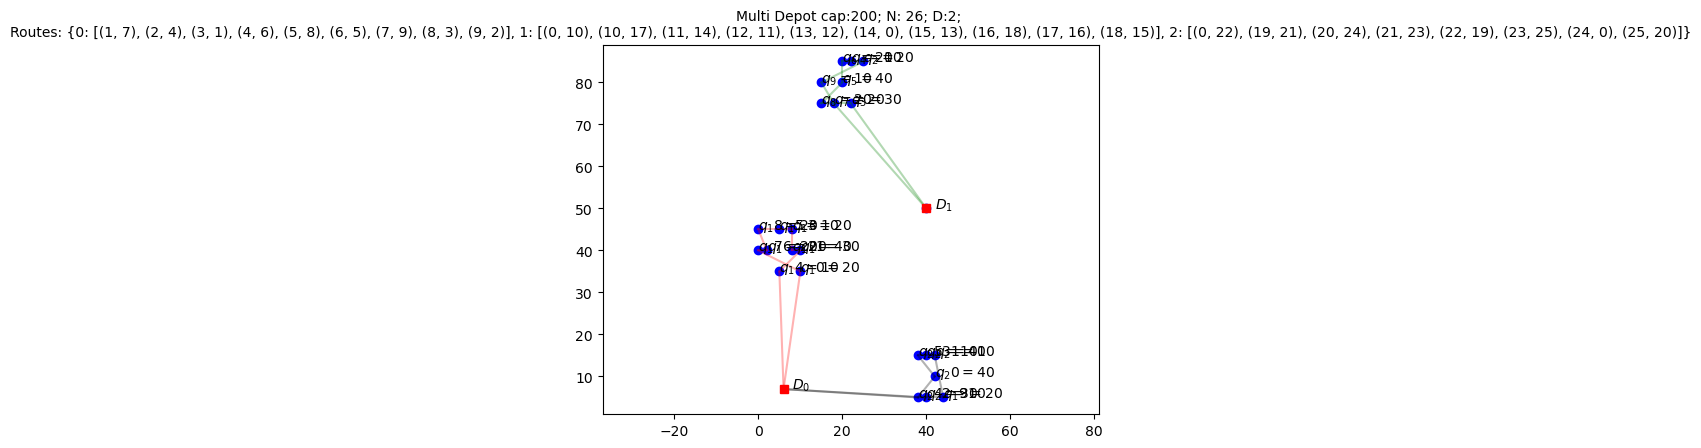

In [6]:
length = 25
file = pd.read_csv("https://raw.githubusercontent.com/mayashenoi/DO/refs/heads/main/rc101.txt", delim_whitespace=True, nrows=length)
vrptw_cplex(file, capacity=200, depot_number=2, vehicle_number=3)